# Metrics
Authors: Ruslan Mammadov \<ruslanmammadov48@gmail.com\>, Flora Geske, David Francisco \<Dfrancisco1998@gmail.com\>

Copyright (C) 2021 Ruslan Mammadov, Flora Geske, David Francisco, and DynaGroup i.T. GmbH

# Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sacrebleu > /dev/null
!pip install rouge > /dev/null
!pip install datasets > /dev/null
!pip install rouge_score > /dev/null
!pip install sentencepiece > /dev/null
!pip install bert_score > /dev/null

In [ ]:
# Example sentences
references_batch = [['The dog bit the man.', 'The dog had bit the man.'],
                    ['It was not unexpected.', 'No one was surprised.'],
                    ['The man bit him first.', 'The man had bitten the dog.']]
input_batch = one_reference_batch = [references[0] for references in references_batch]

output_batch = ['The dog bit the man.', "It wasn't surprising.", 'The man had just bitten him.']

reference = input = "The man bit him first."
output = "The man had bitten the dog."

dog_references = [
    'this is a dog',
    'it is dog truly',
    'dog it is indeed',
    'a dog, it is as fact' 
]
dog_output = 'it is dog in fact'

In [ ]:
reference_tokenized = input_tokenized = "the man bit him first".split()
output_tokenized = "the man had bitten the dog".split()

input_batch_tokenized = one_reference_batch_tokenized = [text.replace(".", "").lower().split() for text in one_reference_batch]
output_batch_tokenized = [text.replace(".", "").lower().split() for text in output_batch]

references_batch_tokenized = [[text.replace(".", "").lower().split() for text in sample] for sample in references_batch]

dog_references_tokenized = [text.replace(",", "").lower().split() for text in dog_references]
dog_output_tokenized = 'it is dog in fact'.split()

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Paraphrasing API/datasets/msr_paraphrase_preds.csv")
df.string_1 = df.string_1.astype(str)
df.string_2 = df.string_2.astype(str)
df.prediction = df.prediction.astype(str)
df.head(3)

,Unnamed: 0,Unnamed: 0.1,string_1,string_2,prediction
0,0,820,The department's position threatens to alienat...,The department's stance disappointed some abor...,The department's position threatens to alienat...
1,1,172,US District Judge William M. Hoeveler's remova...,U.S. District Judge William M. Hoeveler's remo...,US District Judge William Hoeveler's will by h...
2,2,817,The charges came after the federal government ...,The charges came after the federal government ...,The charges came after the federal government ...


# Wrappers

In [ ]:
import numpy as np

def compute_for_every_sample(func, first_argument_batch, second_argument_batch):
  return  [func(arg1, arg2) for arg1, arg2 in zip(first_argument_batch, second_argument_batch)]

def average_over_corpus(sentence_metrics_func, first_argument_batch, second_argument_batch):
  values = compute_for_every_sample(sentence_metrics_func, first_argument_batch, second_argument_batch)
  return sum(values) / len(values)

# Reference based scores

## Bleu and Rouge score

Bleu measures precision: how much the words (and/or n-grams) in the machine generated summaries appeared in the human reference summaries.

Rouge measures recall: how much the words (and/or n-grams) in the human reference summaries appeared in the machine generated summaries.

#### Sacreblue: Use for not tokenized texts!

In [ ]:
# Sacre blue, use that.
# Default choise for bleu score with own tokenizer. It is widely used to get comparable results
from sacrebleu import sentence_bleu, corpus_bleu

print(corpus_bleu(output_batch, references_batch, lowercase=True))
print(sentence_bleu(output, [reference], lowercase=True))

BLEU = 61.88 70.0/62.5/66.7/75.0 (BP = 0.905 ratio = 0.909 hyp_len = 10 ref_len = 11)
BLEU = 14.54 42.9/16.7/10.0/6.2 (BP = 1.000 ratio = 1.167 hyp_len = 7 ref_len = 6)


In [ ]:
import numpy as np
from sacrebleu import sentence_bleu, corpus_bleu

# Wrapper for array, array -> array
def compute_blue_for_every_sample(outputs, references) -> list:

  assert len(np.shape(outputs)) == 1
  if len(np.shape(references)) == 1:
    references = np.expand_dims(references, axis=1).tolist()

  def one_sample_bleu(output, reference):
    return sentence_bleu(output, reference, lowercase=True, smooth_method='exp').score / 100

  return compute_for_every_sample(one_sample_bleu, outputs, references)

def compute_bleu(outputs, references) -> int:

  assert len(np.shape(outputs)) == 1
  if len(np.shape(references)) == 1:
    references = np.expand_dims(references, axis=1).tolist()

  return corpus_bleu(list(outputs), references, lowercase=True).score / 100

print(compute_bleu(df.prediction, df.string_2))
print(np.mean(compute_blue_for_every_sample(df.prediction, df.string_2)))

0.5990578279954589
0.24620310649457844


#### NTLK Implementation: Use for tokenized texts!

In [ ]:
# Ntlk scores for comparision, use if your data is already tokenized, and you like the current tokenizer
from nltk.translate import bleu_score

# Smooting method -> what happens if there are no common 1-4 ngrams?
# method 4 -> reweighting -> good method
smoothing_function = bleu_score.SmoothingFunction().method4

def get_bleu_tokenized(reference, output):
    return bleu_score.sentence_bleu([reference], output, smoothing_function=smoothing_function)

def get_bleu_tokenized_multiple_references(references, output):
    return bleu_score.sentence_bleu(references, output, smoothing_function=smoothing_function)

def get_bleu_corpus_tokenized(reference_batch, output_batch):
    reference_batch = [[text] for text in reference_batch]
    return bleu_score.corpus_bleu(reference_batch, output_batch, smoothing_function=smoothing_function)

def get_bleu_corpus_tokenized_multiple_references(reference_batch, output_batch):
    return bleu_score.corpus_bleu(reference_batch, output_batch, smoothing_function=smoothing_function) 

print(reference_tokenized, output_tokenized)
print(get_bleu_tokenized(reference_tokenized, output_tokenized))
print(get_bleu_tokenized_multiple_references(dog_references_tokenized, dog_output_tokenized))
print('--------------------')
print(get_bleu_corpus_tokenized(one_reference_batch_tokenized, output_batch_tokenized))
print(get_bleu_corpus_tokenized_multiple_references(references_batch_tokenized, output_batch_tokenized))

['the', 'man', 'bit', 'him', 'first'] ['the', 'man', 'had', 'bitten', 'the', 'dog']
0.22141179722338475
0.38440009661674196
--------------------
0.4371701005205063
0.481334461755719


In [ ]:
output_tokenized

['the', 'man', 'had', 'bitten', 'the', 'dog']

## F1 metrics from Bleu and Rouge
Short version: one can use the F1 measure to make the metrics work together: F1 = 2 * (Bleu * Rouge) / (Bleu + Rouge)

Reason: Naturally - Bleu and Rouge results are complementing, as is often the case in precision vs recall. If you have many words/ngrams from the system results appearing in the human references you will have high Bleu, and if you have many words/ngrams from the human references appearing in the system results you will have high Rouge.

There's something called brevity penalty, which is quite important and has already been added to standard Bleu implementations. It penalizes system results which are shorter than the general length of a reference (read more about it here). This complements the n-gram metric behavior which in effect penalizes longer than reference results, since the denominator grows the longer the system result is.

You could also implement something similar for Rouge, but this time penalizing system results which are longer than the general reference length, which would otherwise enable them to obtain artificially higher Rouge scores (since the longer the result, the higher the chance you would hit some word appearing in the references). In Rouge we divide by the length of the human references, so we would need an additional penalty for longer system results which could artificially raise their Rouge score.

#### Rouge python implementation

In [ ]:
from datasets import load_metric
rouge = load_metric("rouge")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [ ]:
def compute_rouge(outputs, references, only_averages=True):
    assert len(np.shape(outputs)) == 1
    assert len(np.shape(references)) == 1

    results = rouge.compute(predictions=outputs, references=references)
    if only_averages:
      for key, value in results.items():
        results[key] = value.mid
    return results

rouge_results = compute_rouge(df.prediction, df.string_2)
rouge_results

{'rouge1': Score(precision=0.5440751337162673, recall=0.5217869214667837, fmeasure=0.5225755063324635),
 'rouge2': Score(precision=0.3479187347455047, recall=0.3289211321185298, fmeasure=0.33113314864053994),
 'rougeL': Score(precision=0.5033288712903872, recall=0.4805370513308267, fmeasure=0.48217195036427385),
 'rougeLsum': Score(precision=0.5030677782680595, recall=0.48022754500597775, fmeasure=0.48211377930275345)}

### GLUE - Google BLUE, like BLUE, but better

In [ ]:
from rouge_score import tokenize
from nltk.translate import gleu_score

In [ ]:
def tokenize_for_reference_based_metrics(outputs, references):
  outputs_tok = [str(tokenize.tokenize(sample, stemmer=None)) for sample in outputs]
  if len(np.shape(references)) == 2:
    references_tok = [[str(tokenize.tokenize(reference, stemmer=None)) for reference in sample] for sample in references]
  elif len(np.shape(references)) == 1:
    references_tok = [str(tokenize.tokenize(sample, stemmer=None)) for sample in references]
  else:
    raise Exception(f"Dim of references should be 1 or 2, not {len(np.shape(references))}!")

  return outputs_tok, references_tok


def compute_gleu_for_every_sample(outputs, references, min_len=1, max_len=4):
  assert len(np.shape(outputs)) == 1
  if len(np.shape(references)) == 1:
    references = np.expand_dims(references, axis=1).tolist()

  outputs_tok, references_tok = tokenize_for_reference_based_metrics(outputs, references)

  def sample_glue(output, reference):
    return gleu_score.sentence_gleu(references=reference, hypothesis=output, 
                                    min_len=min_len, max_len=max_len)

  return compute_for_every_sample(sample_glue, outputs_tok, references_tok)

def compute_gleu(outputs, references, min_len=1, max_len=4):
  assert len(np.shape(outputs)) == 1
  if len(np.shape(references)) == 1:
    references = np.expand_dims(references, axis=1).tolist()

  outputs_tok, references_tok = tokenize_for_reference_based_metrics(outputs, references)

  return gleu_score.corpus_gleu(list_of_references=references_tok, hypotheses=outputs_tok)

In [ ]:
results = compute_gleu_for_every_sample(df.prediction, df.string_2)
compute_gleu(df.prediction, df.string_2)

0.6459360293531148

### BLEURT - Bert model fine-tuned to replace BLEU score!

In [ ]:
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip .
!unzip BLEURT-20.zip

--2021-11-26 21:14:53--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2140294207 (2.0G) [application/octet-stream]
Saving to: ‘BLEURT-20.zip’

BLEURT-20.zip       100%[===================>]   1.99G  50.4MB/s    in 43s     

2021-11-26 21:15:37 (47.7 MB/s) - ‘BLEURT-20.zip’ saved [2140294207/2140294207]

--2021-11-26 21:15:37--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-11-26 21:15:37--
Total wall clock time: 44s
Downloaded: 1 files, 2.0G in 43s (47.7 MB/s)
Archive:  BLEURT-20.zip
   creating: BLEURT-20/
  inflating: BLEURT-20/bert_config.json  
  inflating: BLEURT-20/saved_model.pb  
   creating: BLEURT-20/variables/
  in

In [ ]:
!rm ./bleurt -r
!rm ./bleurt_temp -r
!git clone https://github.com/google-research/bleurt.git
!mv bleurt bleurt_temp
!cp bleurt_temp/bleurt bleurt -r

rm: cannot remove './bleurt': No such file or directory
rm: cannot remove './bleurt_temp': No such file or directory
Cloning into 'bleurt'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 116 (delta 32), reused 55 (delta 20), pack-reused 40
Receiving objects: 100% (116/116), 31.27 MiB | 23.95 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [ ]:
from bleurt import score

checkpoint = "BLEURT-20"
references = ["This is a test."]
candidates = ["This is the test."]

scorer = score.BleurtScorer(checkpoint)
scores = scorer.score(references=df.string_2, candidates=df.prediction)

scores[:5]

INFO:tensorflow:Reading checkpoint BLEURT-20.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint BLEURT-20
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:BLEURT-20
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:... vocab_file:None
INFO:tensorflow:... do_lower_case:None
INFO:tensorflow:... sp_model:sent_piece
INFO:tensorflow:... dynamic_seq_length:True
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.
INFO:tensorflow:SentencePiece tokenizer created.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


[0.7310628294944763,
 0.6159622669219971,
 0.7434067130088806,
 0.4484841823577881,
 0.5253711938858032]

In [ ]:
np.mean(scores)

0.5597532601251874

# Semantic similarity scores between input and output

## BERTScore

Paper: https://arxiv.org/pdf/1904.09675.pdf

Implementation & examples: https://colab.research.google.com/drive/1kpL8Y_AnUUiCxFjhxSrxCsc6-sDMNb_Q#scrollTo=SH1lJxsIMjzJ

We propose BERTSCORE, an automatic evaluation metric for text generation.
Analogously to common metrics, BERTSCORE computes a similarity score for
each token in the candidate sentence with each token in the reference sentence.
However, instead of exact matches, we compute token similarity using contextual
embeddings. We evaluate using the outputs of 363 machine translation and image
captioning systems. BERTSCORE correlates better with human judgments and
provides stronger model selection performance than existing metrics. Finally, we
use an adversarial paraphrase detection task to show that BERTSCORE is more
robust to challenging examples when compared to existing metrics.

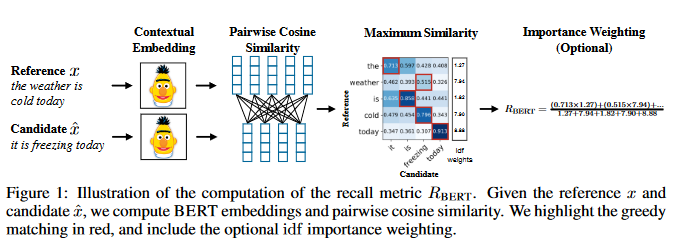

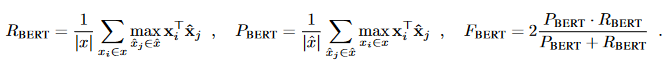

In [ ]:
from datasets import load_metric
bertscore = load_metric("bertscore")

def compute_bert_for_every_sample(inputs, outputs, lang="en", use_fast_tokenizer=False, **kwargs):
  results = bertscore.compute(predictions=outputs, references=inputs, lang=lang, use_fast_tokenizer=use_fast_tokenizer , **kwargs)
  results.pop('hashcode')
  return results

def compute_bert(inputs, outputs, lang="en", use_fast_tokenizer=True, **kwargs):
  results = compute_bert_for_every_sample(inputs, outputs, lang=lang, use_fast_tokenizer=use_fast_tokenizer , **kwargs)
  for key, value in results.items():
    results[key] = np.mean(value)
  return results

results = compute_bert(df.string_1, df.prediction)
results

Downloading:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

{'f1': 0.9507077764242123,
 'precision': 0.9529732381098369,
 'recall': 0.948702675821278}

## SBERT

https://arxiv.org/abs/1908.10084

Compare sentence embeddings of BERT model for reference and the output.

In [ ]:
# Was not taken into account because of lack of time

# Paraphrasic divesity scores

### Diversity tokenizer

In [ ]:
def get_translation_table():
  # Punctuations according to python
  punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

  # Good symbols that should not be removed
  good_symbols = '\'`-'

  # Bad punctuation that should be removed
  bad_punctuations = punctuations.translate("".maketrans("", "", good_symbols))
  
  return "".maketrans(bad_punctuations, ' '*len(bad_punctuations))
  
translation_table = get_translation_table()

def tokenize_text_for_diversity(text):
  # Remove bad punctuation
  text = text.translate(translation_table)
  return text.lower().strip().split()

def tokenize_for_diversity(input, output):
  assert (type(input) == type(output))

  if type(input) == str:
    return tokenize_text_for_diversity(input), tokenize_text_for_diversity(output)
  
  # Input and output are batches
  input_batch = [tokenize_text_for_diversity(text) for text in input]
  output_batch = [tokenize_text_for_diversity(text) for text in output]
  return input_batch, output_batch

In [ ]:
assert((input_batch_tokenized, output_batch_tokenized) == tokenize_for_diversity(input_batch, output_batch))
assert((input_tokenized, output_tokenized) == tokenize_for_diversity(input, output))
(input_batch_tokenized, output_batch_tokenized)

([['the', 'dog', 'bit', 'the', 'man'],
  ['it', 'was', 'not', 'unexpected'],
  ['the', 'man', 'bit', 'him', 'first']],
 [['the', 'dog', 'bit', 'the', 'man'],
  ['it', "wasn't", 'surprising'],
  ['the', 'man', 'had', 'just', 'bitten', 'him']])

## Blue score
1. Compute Blue score between output and input, not reference (!).
2. Calculate blue in both direction and take mean
2. We are interested in diversity => Lower Bleu = higher diversity => better results
3. Measures "Phrasal diversity"

### Implementation

In [ ]:
from nltk.translate import bleu_score

# method 4 -> reweighting
smoothing_function = bleu_score.SmoothingFunction().method4

# Bleu for sentences
def get_bleu_tokenized(sent1, sent2):
  return bleu_score.sentence_bleu([sent1], sent2, smoothing_function=smoothing_function)

def bleu_diversity_tokenized(input, output):
  return (get_bleu_tokenized(input, output) + get_bleu_tokenized(output, input)) / 2

# Final function
def sample_blue_diversity(input, output):
  return bleu_diversity_tokenized(*tokenize_for_diversity(input, output))

# Bleu for corpuses
def get_bleu_corpus_tokenized(input_batch, output_batch):
    input_batch = [[sentence] for sentence in input_batch]
    return bleu_score.corpus_bleu(input_batch, output_batch, smoothing_function=smoothing_function)

def bleu_diversity_corpus_tokenized(input_batch, output_batch):
  return (get_bleu_corpus_tokenized(input_batch, output_batch) + get_bleu_corpus_tokenized(output_batch, input_batch)) / 2

# Final function
def compute_bleu_diversity(input_batch, output_batch):
  return bleu_diversity_corpus_tokenized(*tokenize_for_diversity(input_batch, output_batch))

In [ ]:
print(input, output)
print(sample_blue_diversity(input, output))
print(compute_bleu_diversity(input_batch, output_batch))

The man bit him first. The man had bitten the dog.
0.2081207930152335
0.4473638448084236


## ∩/∪ or Intersection/Union score
1. Number of shared words / number of all words.
2. Higher score = worse diversity
3. Measures "lexical diversity"

### Implementation

In [ ]:
# Function for tokenized
def intersection_over_union_tokenized(input_tokenized, output_tokenized):
  input_tokens = set(input_tokenized)
  output_tokens = set(output_tokenized)
  return len(input_tokens & output_tokens) / len(input_tokens | output_tokens)

# Final function for sentences
def sample_intersection_over_union(input, output):
  return intersection_over_union_tokenized(*tokenize_for_diversity(input, output))

def compute_intersection_over_union(input_batch, output_batch):
  return average_over_corpus(sample_intersection_over_union, input_batch, output_batch)

In [ ]:
print(set(input_tokenized), set(output_tokenized))
print(sample_intersection_over_union(input, output))
print(compute_intersection_over_union(input_batch, output_batch))

{'him', 'man', 'the', 'first', 'bit'} {'had', 'man', 'dog', 'the', 'bitten'}
0.25
0.513888888888889


## Characters N-Gram overlap
1. It is basically the same as intersection over union, but for characters ngram in the tokenized words
2. A little bit better than intersection over union, because it also reacts to small words changes
3. Let's try it out just for the case

#### Implementation

In [ ]:
# Code from interent => it is ugly, sorry
def ngrams(word, n=3):
    return [word[i: i+n] for i in range(len(word) - n + 1)]

# Function for tokanized
def char_ngram_overlap_tokenized(sent1, sent2):
    ngrams1 = {ngram for token in sent1 for n in range(3, 7) for ngram in ngrams(f' {token} ', n=n)}
    ngrams2 = {ngram for token in sent2 for n in range(3, 7) for ngram in ngrams(f' {token} ', n=n)}
    return len(ngrams1 & ngrams2) / len(ngrams1 | ngrams2)

# Final sample function
def sample_char_ngram_overlap(sent1, sent2):
  return char_ngram_overlap_tokenized(*tokenize_for_diversity(sent1, sent2))

def compute_char_ngram_overlap(input_batch, output_batch):
  return average_over_corpus(sample_char_ngram_overlap, input_batch, output_batch)

In [ ]:
print(input_tokenized, output_tokenized)
print(sample_char_ngram_overlap(input, output))
print(compute_char_ngram_overlap(input_batch, output_batch))

['the', 'man', 'bit', 'him', 'first'] ['the', 'man', 'had', 'bitten', 'the', 'dog']
0.23076923076923078
0.4615846338535414


## Tree edit distance of syntactic trees
1. Compute tree distance between syntactic trees of input and output sentences.
2. Higher distance = higher diversity => better result
3. Used in https://aclanthology.org/K19-1005/ and in some other papers
5. Many implementations for syntactic parsing and tree distances.
6. Or we can use nltk's edit_distance, but it is a little bit different.
7. Measures "syntactic diversity"

#### Implementation

Is not important at the moment, it is an advanced metrics which is useful when your paraphrasers are dissimilar on syntax level. Then, if you want to go one level upon and analyse the structure of the sentence. However, it is very time consuming, and is not helpful before you reach high level of text dissimilarity.

# Fluency scores


## Perplexity

It is worth trying, but it requires language model and GPU with memory, and we considered it as not robust.

Perplexity is not used as metrics in research, or at least we have not found it. The problem with perplexity is that is depends on what data the model has seen before, and it also depends strongly on the numver of words and other parameters. 

## Bleurt model
Bleurt model evaluates fluency too, so you can use that.

# Putting all together

In [ ]:
def compute_metrics(input_batch, output_batch, reference_batch, only_fast_metrics=False):
  if np.shape(reference_batch) == 2:
    one_reference_batch = np.array(reference_batch)[:, 0]
  else:
    assert len(np.shape(reference_batch)) == 1
    one_reference_batch = reference_batch
  
  # Similarity to reference
  bleu = compute_bleu(output_batch, reference_batch)
  rouge = compute_rouge(output_batch, one_reference_batch, only_averages=True)

  # Not for diversity!!! Just interesting, for comparison to bleu between output and reference
  bleu_output_input = compute_bleu(output_batch, input_batch)

  if not only_fast_metrics:
    bert = compute_bert(input_batch, output_batch, use_fast_tokenizer=True)
  
  # Diversity
  bleu_diversity = compute_bleu_diversity(input_batch, output_batch)
  intersection_over_union = compute_intersection_over_union(input_batch, output_batch)
  char_ngram_overlap = compute_char_ngram_overlap(input_batch, output_batch)

  results = {
      "bleu": bleu, 
      "bleu_output_input": bleu_output_input,

      # Rouge is annoying
      "rouge1_f1": rouge["rouge1"].fmeasure,
      "rouge1_recall": rouge["rouge1"].recall,
      "rouge1_precision": rouge["rouge1"].precision,
      "rouge2_f1": rouge["rouge2"].fmeasure,
      "rouge2_recall": rouge["rouge2"].recall,
      "rouge2_precision": rouge["rouge2"].precision,
      "rougeL_f1": rouge["rougeL"].fmeasure,
      "rougeL_recall": rouge["rougeL"].recall,
      "rougeL_precision": rouge["rougeL"].precision,
      # Seriously??!!!

      "bleu_diversity": bleu_diversity,
      "intersection_over_union": intersection_over_union,
      "char_ngram_overlap": char_ngram_overlap
  }

  if not only_fast_metrics:
    results = {
        **results,
        "bert_f1":  bert["f1"],
        "bert_precision": bert["precision"],
        "bert_recall": bert["recall"]
    }
  return results

In [ ]:
compute_metrics(df.string_1, df.prediction, df.string_2)

{'bert_f1': 0.9507077764242123,
 'bert_precision': 0.9529732381098369,
 'bert_recall': 0.948702675821278,
 'bleu': 0.5990578279954589,
 'bleu_diversity': 0.5304278392463515,
 'bleu_output_input': 0.888561778354056,
 'char_ngram_overlap': 0.6473552501960912,
 'intersection_over_union': 0.6140761601723921,
 'rouge1_f1': 0.5225755063324635,
 'rouge1_precision': 0.5440751337162673,
 'rouge1_recall': 0.5217869214667837,
 'rouge2_f1': 0.33113314864053994,
 'rouge2_precision': 0.3479187347455047,
 'rouge2_recall': 0.3289211321185298,
 'rougeL_f1': 0.48217195036427385,
 'rougeL_precision': 0.5033288712903872,
 'rougeL_recall': 0.4805370513308267}